In [1]:
pip install scipy

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
#correct the modern Julian dates and exposure times for the Earth's motion around the Sun=
#convert wavelength axis to velocity axis in km/s
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy import units as u
from astropy.constants import c
from astropy.coordinates import SpectralCoord
barycorrlist=[]
sc_nm_list = []
sc_kms_list = []
mjd=[]
ltt_barylist=[]
bjdlist = []
for i in range(1, 22):
    hdul=fits.open(f'VIS_{i:02}.fits')
    mjd.append(hdul[0].header['MJD-OBS'])
    
for i in range(1, 22):
    file = f'VIS_{i:02}.fits'
    hdul = fits.open(file)
    flux_data = hdul[0].data
    header = hdul[0].header
    exposuretime = header['EXPTIME']
    start_wavelength_nm = header['CRVAL1']
    wavelength_step_nm = header['CDELT1']
    pixel_num = np.arange(len(flux_data))
    wavelength_nm = start_wavelength_nm + (pixel_num * wavelength_step_nm)
    sc = SpectralCoord(wavelength_nm, unit='nm')
    sc_kms = sc.to(u.km / u.s, doppler_convention='optical', doppler_rest=656.276 * u.nm)
    sc_nm_list.append(sc)
    sc_kms_list.append(sc_kms)
    print(hdul[0].data)
    print(hdul[1].data)
    
    from astropy import time, coordinates as coord, units as u
    VIS = coord.SkyCoord("21:21:18.6", "-09:43:29.0", unit=(u.hourangle, u.deg), frame='icrs')
    paranal = coord.EarthLocation.of_site('paranal')
    times = time.Time([mjd[i-1]+((exposuretime/2) / 86400.0)], format='mjd', scale='utc', location=paranal)
    barycorr = VIS.radial_velocity_correction(obstime=times)
    barycorrlist.append(barycorr)
    ltt_bary = times.light_travel_time(VIS)
    ltt_barylist.append(ltt_bary)
    time_barycentre = times.tdb + ltt_bary.value.item()
    bjdlist.append(time_barycentre)

    
bary_kmslist = []
for i in range (1,22):
    bary_nm = sc_nm_list[i-1].with_radial_velocity_shift(barycorrlist[i-1])
    bary_kms = bary_nm.to(u.km / u.s, doppler_convention='optical', doppler_rest=656.276 * u.nm)
    bary_kmslist.append(bary_kms)

[-5.3240923e-16 -1.0342304e-15 -3.2360379e-15 ... -1.3219654e-17
  6.5614086e-19  7.8402511e-18]
[6.9876546e-15 7.4673866e-15 7.0617848e-15 ... 2.3413941e-17 2.3185391e-17
 2.2610044e-17]


[ 2.8312798e-15 -3.7403857e-15 -8.5112420e-15 ...  5.8652188e-18
 -2.2502441e-17 -1.9145092e-17]
[6.6713797e-15 6.7735692e-15 6.4095318e-15 ... 2.3274376e-17 2.2852653e-17
 2.3252199e-17]
[ 4.5412824e-15  1.2880822e-15 -7.7334631e-17 ...  1.9953832e-18
  2.3983382e-17  4.9821704e-17]
[7.4063688e-15 7.7250277e-15 7.3033671e-15 ... 2.4245383e-17 2.4538922e-17
 2.4767860e-17]
[ 5.1753988e-15  8.4486149e-15 -3.6062055e-16 ...  4.0277783e-17
  2.7293321e-17  1.2914929e-17]
[6.9490202e-15 7.2502988e-15 6.7844374e-15 ... 2.3066515e-17 2.2670023e-17
 2.2690573e-17]
[ 1.0235705e-14  5.1877981e-15  2.6095262e-15 ... -1.0048094e-17
 -1.9268028e-17 -1.2291016e-18]
[6.8959997e-15 7.3907479e-15 6.8571518e-15 ... 2.0159459e-17 1.9784008e-17
 2.0040608e-17]
[-1.5031491e-15  5.0860720e-15  4.0281160e-15 ...  4.7469454e-17
  4.0931884e-17  2.8898766e-17]
[7.0117438e-15 7.3455358e-15 6.9452407e-15 ... 2.1862503e-17 2.1993470e-17
 2.1555553e-17]
[-9.5952824e-16  4.8967652e-15  2.2322361e-15 ...  1.5460069

In [3]:
#interpolation (pre-monte carlo), the common_velocity_axis cut off both ends that have noises
#produce trailing_data which spans a wide range
import scipy
c = 2.998e5
def compute_trailing_data(file_list, bary_kmslist, binsize):
    common_velocity_axis = np.arange((c*(5465-6562.76))/6562.76, ((c*(10000-6562.76))/6562.76)+binsize, binsize)
    resampled_flux_list = []
    
    for i, fitfile in enumerate(file_list):
        hdul = fits.open(fitfile)
        flux_data = hdul[0].data    
        original_velocity_axis = bary_kmslist[i]
        f = scipy.interpolate.interp1d(original_velocity_axis, flux_data, kind='cubic', bounds_error=False, fill_value=np.nan)
        resampled_flux = f(common_velocity_axis)
        resampled_flux_list.append(resampled_flux)

    trailing_data = np.array(resampled_flux_list)
    return trailing_data, common_velocity_axis


/tmp/ipykernel_343022/3708655265.py:6: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  orbitalphase = [float(np.mod((btime - T0).value / P, 1)) for btime in bjdlist]


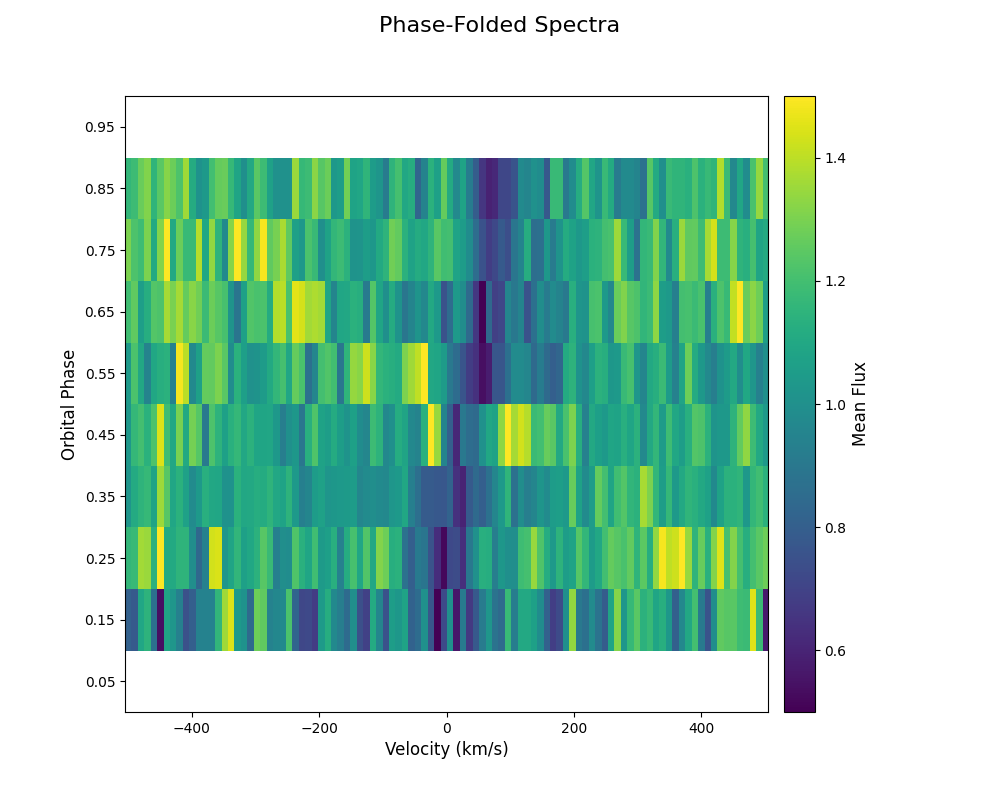

In [4]:
#produce orbital phase from the bjdlist which contains the MBJD Modern Barycentre Julian Dates
def orbitalphasefunc():
    T0_val = 59385.541376
    P = 0.0953979016
    T0 = time.Time(T0_val, format='mjd', scale='tdb')
    orbitalphase = [float(np.mod((btime - T0).value / P, 1)) for btime in bjdlist]
    return orbitalphase
    
#plot the spectra by binning the orbital phases
def plot_orbitalphase_spectra(file_list, bary_kmslist, min_v, max_v, binsize, phase_bin_size):
    %matplotlib widget
    trailing_data, common_velocity_axis = compute_trailing_data(file_list, bary_kmslist, binsize)
    n_files = len(trailing_data)

    median_flux = np.median(trailing_data)
    
    normalised_trailing_data = trailing_data/median_flux
    vmin = 0.5 * np.median(normalised_trailing_data)
    vmax = 1.5 * np.median(normalised_trailing_data)
    velocitymask = (common_velocity_axis > min_v) & (common_velocity_axis < max_v)
    normalised_trailing_data_masked = normalised_trailing_data[:,velocitymask]
    
    phase_bins = np.arange(0.0, 1.0, phase_bin_size)
    binned_spectra_list = []
    orbitalphase = orbitalphasefunc()

    for start_phase in phase_bins:
        end_phase = start_phase + phase_bin_size
        phase_mask = (np.array(orbitalphase) >= start_phase) & (np.array(orbitalphase) < end_phase)
        fluxes_in_bin = normalised_trailing_data_masked[phase_mask]

        if fluxes_in_bin.shape[0] > 0:
            mean_flux_for_bin = np.mean(fluxes_in_bin, axis=0)
        else:
            mean_flux_for_bin = np.full(len(common_velocity_axis[velocitymask]), np.nan)

        binned_spectra_list.append(mean_flux_for_bin)

    phase_data = np.ma.masked_invalid(np.array(binned_spectra_list))

    fig, ax = plt.subplots(figsize=(10, 8))
    
    im = ax.imshow(phase_data, extent=[min_v - binsize / 2, max_v + binsize / 2, 0, 1],
                   origin='lower', aspect='auto', cmap='viridis', vmin=vmin, vmax=vmax)

    cbar = fig.colorbar(im, ax=ax, pad=0.02)
    cbar.set_label('Mean Flux', fontsize=12)

    ax.set_xlabel('Velocity (km/s)', fontsize=12)
    ax.set_ylabel('Orbital Phase', fontsize=12)
    plt.suptitle('Phase-Folded Spectra', fontsize=16)

    ax.set_yticks(phase_bins + phase_bin_size / 2)
    ax.set_yticklabels([f'{p:.2f}' for p in phase_bins + phase_bin_size / 2])
    plt.show()

fits_files = [f'VIS_{i:02}.fits' for i in range(1, 22)]
plot_orbitalphase_spectra(fits_files, bary_kmslist, -500, 500, 10, 0.1)

/tmp/ipykernel_343022/3708655265.py:6: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  orbitalphase = [float(np.mod((btime - T0).value / P, 1)) for btime in bjdlist]


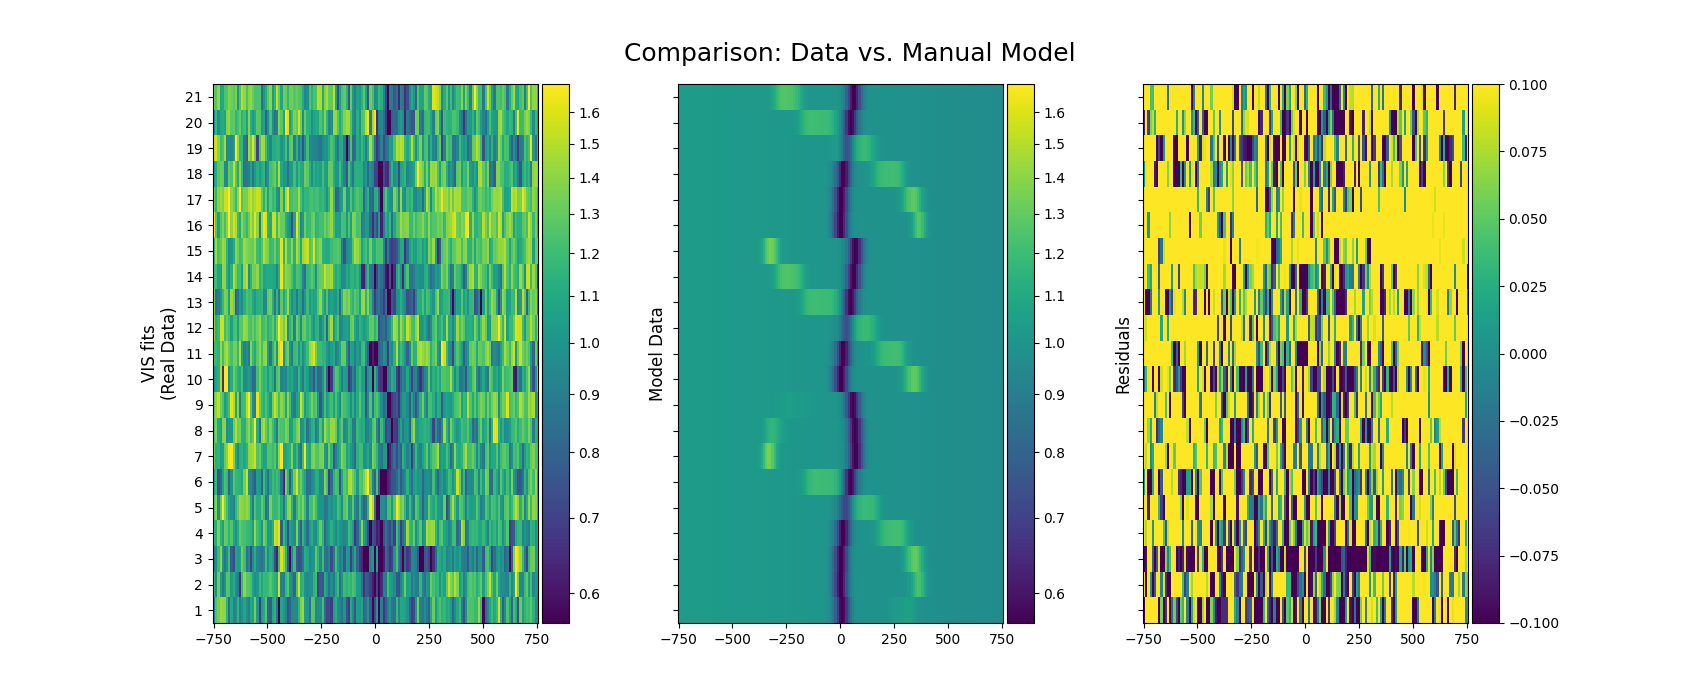

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from astropy.modeling import models
#import the fit files
#the main issue is that requires the median to be from the wide range of fluxes, corresponding to trailing_data
#and common_velocity_axis, but only want to plot the range -750 to 750, corresponding to 
#normalised_trailing_data_masked and common_velocity_axis[velocity_mask]

fits_files = [f'VIS_{i:02}.fits' for i in range(1, 22)]
min_v, max_v, binsize = -750, 750, 10
trailing_data, common_velocity_axis = compute_trailing_data(fits_files, bary_kmslist, binsize)
velocity_mask = (common_velocity_axis >= min_v) & (common_velocity_axis <= max_v)

#modified function to return flux arrays instead of plotting
def plot_trailing_spectra_modified(file_list, bary_kmslist, min_v, max_v, binsize):
    n_files = len(trailing_data) #this is to calculate the number of spectra, not fluxes
    median_flux = np.median(trailing_data) #this is to take the median of all the fluxes across all spectra
    normalised_trailing_data = trailing_data/median_flux
    normalised_trailing_data_masked = normalised_trailing_data[:,velocity_mask]
    vmin = 0.5 * np.median(normalised_trailing_data_masked)
    vmax = 1.5 * np.median(normalised_trailing_data_masked)
#vmin, vmax are flux values.
    
    norm = colors.LogNorm(vmin=vmin, vmax=vmax)
    plot_extent = [min_v - binsize / 2, max_v + binsize / 2, 0.5, n_files + 0.5]
    fig, axes = plt.subplots(1,3, figsize=(17, 7), sharex=True, sharey=True, gridspec_kw={'hspace': 0.15})
    fig.suptitle('Comparison: Data vs. Manual Model', fontsize=18, y=0.94)

    im1 = axes[0].imshow(normalised_trailing_data_masked, interpolation='nearest', extent=plot_extent,
                         origin='lower', aspect='auto', norm=norm, cmap='viridis')

    axes[0].set_ylabel('VIS fits\n(Real Data)', fontsize=12)
    axes[0].set_yticks(np.arange(1, n_files + 1))
    cbar1 = fig.colorbar(im1, ax=axes[0], pad=0.01)
    ticks = [0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6]
    cbar1.set_ticks(ticks) 
    formatted_ticks = ["%.1f" % t for t in ticks]
    cbar1.set_ticklabels(formatted_ticks)
    return fig, axes, normalised_trailing_data_masked, norm, plot_extent
    
#function of the model with smearing effects   
def generate_model_data(orbitalphase, common_velocity_axis, P_orb_days,
                        gamma_wd, k_wd, wd_amp, wd_std,
                        gamma_bd, k_emis, bd_amp, bd_std,
                        slope, intercept,
                        exposure_time_s=600.0, n_bins=18):
    model_spectra_list = []

    # Calculate the phase change for each time bin within the exposure
    time_offsets = np.linspace(-exposure_time_s / 2.0, exposure_time_s / 2.0, n_bins)
    phase_offsets = time_offsets / (P_orb_days * 86400.0) 

    # Loop through each observation's mid-exposure phase
    for mid_phase in orbitalphase:
        sub_spectra = []
        
        # For each mid-phase, calculate the model at each time bin
        for offset in phase_offsets:
            current_phase = mid_phase + offset

            linear_background = models.Linear1D(slope=slope, intercept=intercept)

            mean_wd = gamma_wd - k_wd * np.sin(2 * np.pi * current_phase)
            gauss_wd = models.Gaussian1D(amplitude=wd_amp, mean=mean_wd, stddev=wd_std)

            mean_bd = gamma_bd + k_emis * np.sin(2 * np.pi * current_phase)
            amplitude_bd = -bd_amp * (1 - np.cos(2 * np.pi * current_phase)) / 2.0
            gauss_bd = models.Gaussian1D(amplitude=amplitude_bd, mean=mean_bd, stddev=bd_std)
            
            composite_model = linear_background + gauss_wd + gauss_bd
            model_flux_for_bin = composite_model(common_velocity_axis[velocity_mask]) #this is one spectra at one particular phase bin
            sub_spectra.append(model_flux_for_bin) #this is one spectra at all bins

        # Average the binned spectra to create the final, smeared spectrum
        smeared_spectrum = np.mean(sub_spectra, axis=0)
        model_spectra_list.append(smeared_spectrum)

    return np.array(model_spectra_list)

def plot_comparison():
    fig, axes, real_data, data_norm, plot_extent = \
        plot_trailing_spectra_modified(trailing_data, common_velocity_axis[velocity_mask], min_v, max_v, binsize)

    manual_model_params = {
        'gamma_wd': 30.0, 'k_wd': 35.0, 'wd_amp': -0.45, 'wd_std': 25.0,
        'gamma_bd': 10.0, 'k_emis': 350.0, 'bd_amp': -0.65, 'bd_std': 20.0,
        'slope': -0.00005, 'intercept': 1.0
    }
    orbitalphase = orbitalphasefunc() 
    P = 0.0953979016
    
    model_data = generate_model_data(orbitalphase, common_velocity_axis, P_orb_days=P, **manual_model_params)

    im2 = axes[1].imshow(model_data, interpolation='nearest', extent=plot_extent,
                         origin='lower', aspect='auto', norm=data_norm, cmap='viridis')
    axes[1].set_ylabel('Model Data', fontsize=12)
    cbar2 = fig.colorbar(im2, ax=axes[1], pad=0.01)
    ticks = [0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6]
    cbar2.set_ticks(ticks) 
    formatted_ticks = ["%.1f" % t for t in ticks]
    cbar2.set_ticklabels(formatted_ticks)
 
    residual = real_data - model_data
    res_norm = colors.Normalize(vmin=-0.1, vmax=0.1)
    
    im3 = axes[2].imshow(residual, interpolation='nearest', extent=plot_extent,
                         origin='lower', aspect='auto', norm=res_norm, cmap='viridis')
    cbar3 = fig.colorbar(im3, ax=axes[2], pad=0.01)
    axes[2].set_ylabel('Residuals', fontsize=12)
    
    plt.show()
    plt.savefig("comparison.png")


plot_comparison()

import numpy as np
import scipy.interpolate
from astropy.io import fits

c = 2.998e5 # Speed of light in km/s

def compute_trailing_data_mc(file_list, bary_kmslist, binsize, n_mc=200):
    """
    Performs Monte Carlo interpolation to generate resampled spectra and their errors.

    Args:
        file_list (list): List of FITS file paths.
        bary_kmslist (list): List of original velocity axes for each file.
        binsize (float): The velocity bin size for the common axis.
        n_mc (int): The number of Monte Carlo iterations.

    Returns:
        tuple: A tuple containing:
            - np.array: The mean interpolated flux data (trailing data).
            - np.array: The standard deviation of the interpolated flux (errors).
            - np.array: The common velocity axis.
    """
    # Define the wide common velocity axis
    lambda_ref = 6562.76
    lambda_min, lambda_max = 5465, 10000
    v_start = (c * (lambda_min - lambda_ref)) / lambda_ref
    v_end = (c * (lambda_max - lambda_ref)) / lambda_ref
    common_velocity_axis = np.arange(v_start, v_end + binsize, binsize)

    # Lists to store the final results for each spectrum
    final_mean_fluxes = []
    final_std_dev_fluxes = []

    for i, fitfile in enumerate(file_list):
        with fits.open(fitfile) as hdul:
            flux_data = hdul[0].data
            flux_error = hdul[1].data 
        original_velocity_axis = bary_kmslist[i]

        simulated_fluxes = np.random.normal(
            loc=flux_data, 
            scale=flux_error, 
            size=(n_mc, len(flux_data)))

        # List to store the results of interpolating each simulated spectrum
        resampled_per_spectra = []

        # Loop through each of the n_mc simulated flux arrays
        for j in range(n_mc):
            f = scipy.interpolate.interp1d(
                original_velocity_axis, 
                simulated_fluxes[j, :], # A single row from our simulated data
                kind='cubic', 
                bounds_error=False, 
                fill_value=np.nan)
            resampled_100_spectra = f(common_velocity_axis)
            resampled_per_spectra.append(resampled_100_spectra)

        # Convert the list of resampled spectra into a 2D numpy array
        # Shape will be (n_mc, number_of_common_velocity_bins)
        resampled_per_spectra = np.array(resampled_per_spectra)

        # Calculate the mean and standard deviation along the Monte Carlo axis (axis=0)
        mean_flux = np.nanmean(resampled_per_spectra, axis=0)
        std_dev_flux = np.nanstd(resampled_per_spectra, axis=0)

        final_mean_fluxes.append(mean_flux)
        final_std_dev_fluxes.append(std_dev_flux)

    return np.array(final_mean_fluxes), np.array(final_std_dev_fluxes), common_velocity_axis
trailing_data, trailing_data_error, common_velocity_axis = compute_trailing_data_mc(fits_files, bary_kmslist, binsize)
output_filename = 'trailing_data_with_errors.npz'
#saving the three arrays into a file
np.savez_compressed(
        output_filename, 
        mean_flux=trailing_data, 
        error_flux=trailing_data_error, 
        velocity_axis=common_velocity_axis)

/tmp/ipykernel_343022/3708655265.py:6: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  orbitalphase = [float(np.mod((btime - T0).value / P, 1)) for btime in bjdlist]


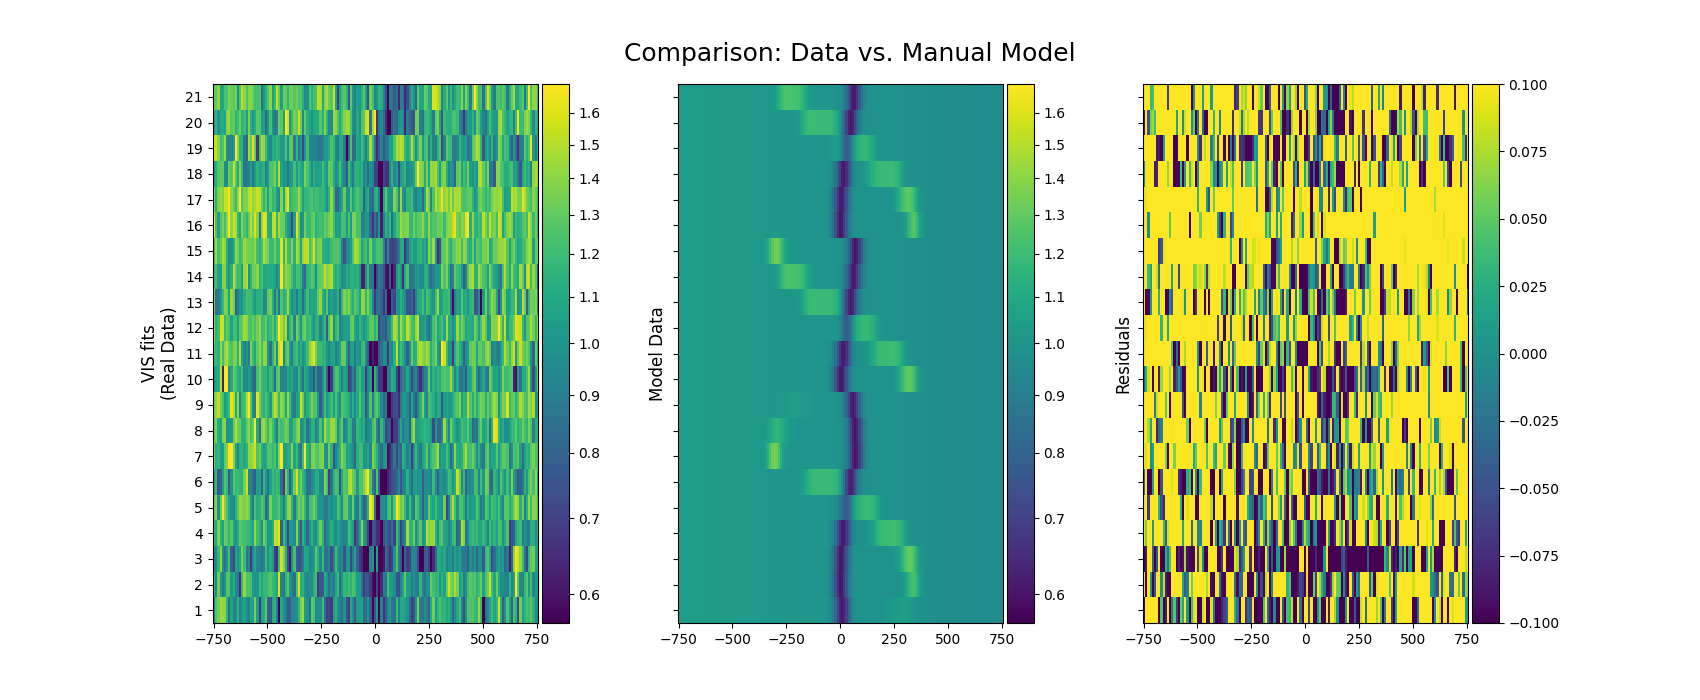

[[5.08011816e-17 5.34231540e-17 5.40379373e-17 ... 1.51548354e-17
  1.52451486e-17 1.38249053e-17]
 [4.26369470e-17 5.15931035e-17 5.62764126e-17 ... 1.47603422e-17
  1.36685895e-17 1.30686555e-17]
 [5.09524866e-17 5.68724107e-17 4.95093027e-17 ... 1.41581652e-17
  1.38559782e-17 1.40455004e-17]
 ...
 [5.33218868e-17 5.42468552e-17 5.27130437e-17 ... 1.02651944e-17
  9.24125456e-18 9.87435493e-18]
 [5.31976811e-17 5.20699919e-17 5.08147230e-17 ... 8.95904000e-18
  9.52422131e-18 8.29678306e-18]
 [4.86431305e-17 4.67065135e-17 4.95031166e-17 ... 8.70580284e-18
  8.55965219e-18 8.13226616e-18]]


In [6]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from astropy.modeling import models
#import the fit files
#the main issue is that the median needs to be from the wide range of fluxes, corresponding to trailing_data
#and common_velocity_axis, but only want to plot the range -750 to 750, corresponding to 
#normalised_trailing_data_masked and common_velocity_axis[velocity_mask]

output_filename = 'trailing_data_with_errors.npz'
data = np.load(output_filename)
trailing_data = data['mean_flux']
trailing_data_error = data['error_flux']
common_velocity_axis = data['velocity_axis']
fits_files = [f'VIS_{i:02}.fits' for i in range(1, 22)]
min_v, max_v, binsize = -750, 750, 10
velocity_mask = (common_velocity_axis >= min_v) & (common_velocity_axis <= max_v)
#unload the file


#modified function to return flux arrays instead of plotting
def plot_trailing_spectra_modified(file_list, bary_kmslist, min_v, max_v, binsize):
    n_files = len(trailing_data) #this is to calculate the number of spectra, not fluxes
    median_flux = np.median(trailing_data) #this is to take the median of all the fluxes across all spectra
    normalised_trailing_data = trailing_data/median_flux
    normalised_trailing_data_masked = normalised_trailing_data[:,velocity_mask]
    vmin = 0.5 * np.median(normalised_trailing_data_masked)
    vmax = 1.5 * np.median(normalised_trailing_data_masked)
#vmin, vmax are flux values.
    
    norm = colors.LogNorm(vmin=vmin, vmax=vmax)
    plot_extent = [min_v - binsize / 2, max_v + binsize / 2, 0.5, n_files + 0.5]
    fig, axes = plt.subplots(1,3, figsize=(17, 7), sharex=True, sharey=True, gridspec_kw={'hspace': 0.15})
    fig.suptitle('Comparison: Data vs. Manual Model', fontsize=18, y=0.94)

    im1 = axes[0].imshow(normalised_trailing_data_masked, interpolation='nearest', extent=plot_extent,
                         origin='lower', aspect='auto', norm=norm, cmap='viridis')

    axes[0].set_ylabel('VIS fits\n(Real Data)', fontsize=12)
    axes[0].set_yticks(np.arange(1, n_files + 1))
    cbar1 = fig.colorbar(im1, ax=axes[0], pad=0.01)
    ticks = [0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6]
    cbar1.set_ticks(ticks) 
    formatted_ticks = ["%.1f" % t for t in ticks]
    cbar1.set_ticklabels(formatted_ticks)
    return fig, axes, normalised_trailing_data_masked, norm, plot_extent
    
#function of the model with smearing effects   
def generate_model_data(orbitalphase, common_velocity_axis, P_orb_days,
                        gamma_wd, k_wd, wd_amp, wd_std,
                        gamma_bd, k_emis, bd_amp, bd_std,
                        slope, intercept,
                        exposure_time_s=600.0, n_bins=6):
    model_spectra_list = []

    # Calculate the phase change for each time bin within the exposure
    time_offsets = np.linspace(-exposure_time_s / 2.0, exposure_time_s / 2.0, n_bins)
    phase_offsets = time_offsets / (P_orb_days * 86400.0) 

    # Loop through each observation's mid-exposure phase
    for mid_phase in orbitalphase:
        sub_spectra = []
        
        # For each mid-phase, calculate the model at each time bin
        for offset in phase_offsets:
            current_phase = mid_phase + offset

            linear_background = models.Linear1D(slope=slope, intercept=intercept)

            mean_wd = gamma_wd - k_wd * np.sin(2 * np.pi * current_phase)
            gauss_wd = models.Gaussian1D(amplitude=wd_amp, mean=mean_wd, stddev=wd_std)

            mean_bd = gamma_bd + k_emis * np.sin(2 * np.pi * current_phase)
            amplitude_bd = -bd_amp * (1 - np.cos(2 * np.pi * current_phase)) / 2.0
            gauss_bd = models.Gaussian1D(amplitude=amplitude_bd, mean=mean_bd, stddev=bd_std)
            
            composite_model = linear_background + gauss_wd + gauss_bd
            model_flux_for_bin = composite_model(common_velocity_axis[velocity_mask]) 
            #this is one spectrum at one particular phase bin
            sub_spectra.append(model_flux_for_bin) #this is one spectrum at all bins

        # Average the binned spectra to create the final, smeared spectrum
        smeared_spectrum = np.mean(sub_spectra, axis=0)
        model_spectra_list.append(smeared_spectrum)

    return np.array(model_spectra_list)

def plot_comparison():
    fig, axes, real_data, data_norm, plot_extent = \
        plot_trailing_spectra_modified(trailing_data, common_velocity_axis[velocity_mask], min_v, max_v, binsize)

    manual_model_params = {
        'gamma_wd': 30.0, 'k_wd': 35.0, 'wd_amp': -0.40, 'wd_std': 25.0,
        'gamma_bd': 10.0, 'k_emis': 325.0, 'bd_amp': -0.65, 'bd_std': 20.0,
        'slope': -0.00005, 'intercept': 1.0
    }
    orbitalphase = orbitalphasefunc() 
    P = 0.0953979016
    
    model_data = generate_model_data(orbitalphase, common_velocity_axis, P_orb_days=P, **manual_model_params)

    im2 = axes[1].imshow(model_data, interpolation='nearest', extent=plot_extent,
                         origin='lower', aspect='auto', norm=data_norm, cmap='viridis')
    axes[1].set_ylabel('Model Data', fontsize=12)
    cbar2 = fig.colorbar(im2, ax=axes[1], pad=0.01)
    ticks = [0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6]
    cbar2.set_ticks(ticks) 
    formatted_ticks = ["%.1f" % t for t in ticks]
    cbar2.set_ticklabels(formatted_ticks)
 
    residual = real_data - model_data
    res_norm = colors.Normalize(vmin=-0.1, vmax=0.1)
    
    im3 = axes[2].imshow(residual, interpolation='nearest', extent=plot_extent,
                         origin='lower', aspect='auto', norm=res_norm, cmap='viridis')
    cbar3 = fig.colorbar(im3, ax=axes[2], pad=0.01)
    axes[2].set_ylabel('Residuals', fontsize=12)
    
    plt.show()
    plt.savefig("comparison.png")


plot_comparison()
print(trailing_data_error)